# TODO
- [ ] Arrume o codigo
- [ ] Melhore a RNN
    - [ ] Coloque mais Layers
    - [ ] coloque mais RNNs
    - [ ] Coloque uma linear no final
- [ ] Faça uma GRU bonitinha
- [ ] Faça uma LSTM bonitinha

In [1]:
from collections import defaultdict
from torchviz import make_dot
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
import numpy as np
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [7]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = torch.tensor(series[:7000, :n_steps]), torch.tensor(series[:7000, -1])
X_valid, y_valid = torch.tensor(series[7000:9000, :n_steps]), torch.tensor(series[7000:9000, -1])
X_test, y_test = torch.tensor(series[9000:, :n_steps]), torch.tensor(series[9000:, -1])

In [8]:
X_train.shape, y_train.shape

(torch.Size([7000, 50, 1]), torch.Size([7000, 1]))

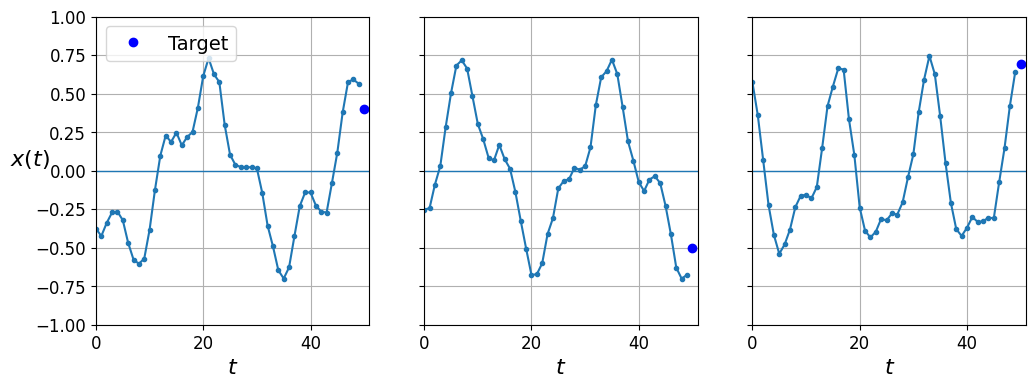

In [9]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

In [10]:
# Se eu quisesse colocar o ultimo valor em como o predict
y_pred = X_valid[:, -1]

In [11]:
mean_absolute_error(y_valid, y_pred)

0.11627829

In [12]:
mean_squared_error(y_valid, y_pred)

0.020211367

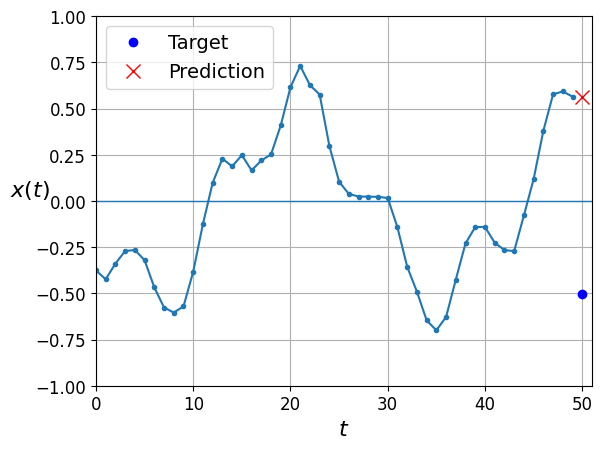

In [13]:
plot_series(X_valid[0, :, 0], y_valid[1, 0], y_pred[0, 0])
plt.show()

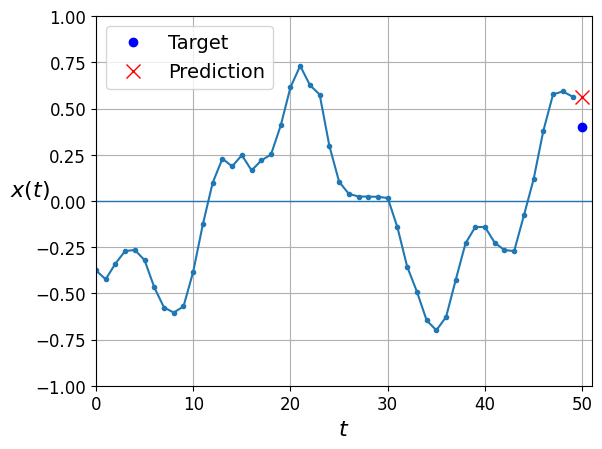

In [14]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [15]:
# X_train = X_train.permute(1,0,2)
# X_valid = X_valid.permute(1,0,2)
# X_test = X_test.permute(1,0,2)

In [16]:
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=None, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=None, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=None, shuffle=False)

In [18]:
X, y = next(iter(train_dataloader))

In [19]:
L = 50
N = 7000
H_in = 1
H_out = 1
N_layers = 1

# RNN

In [20]:
class MyFirstRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(H_in, H_out, N_layers, batch_first=True)

    def forward(self, x):
        out, h_i = self.rnn(x)
        return out[-1]

In [21]:
model = MyFirstRNN()

In [22]:
summary(model, (50,1), verbose=2)

Layer (type:depth-idx)                   Output Shape              Param #
MyFirstRNN                               [1]                       --
├─RNN: 1-1                               [50, 1]                   4
│    └─weight_ih_l0                                                ├─1
│    └─weight_hh_l0                                                ├─1
│    └─bias_ih_l0                                                  ├─1
│    └─bias_hh_l0                                                  └─1
Total params: 4
Trainable params: 4
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
MyFirstRNN                               [1]                       --
├─RNN: 1-1                               [50, 1]                   4
│    └─weight_ih_l0                                                ├─1
│    └─weight_hh_l0                                                ├─1
│    └─bias_ih_l0                                                  ├─1
│    └─bias_hh_l0                                                  └─1
Total params: 4
Trainable params: 4
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [23]:
LR = 1e-4
EPOCHS = 3
train_logs = defaultdict(list)

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

In [25]:
model.to(device)

MyFirstRNN(
  (rnn): RNN(1, 1, batch_first=True)
)

In [26]:
optimizer.zero_grad(set_to_none=True)
for epoch in tqdm(range(EPOCHS)):
    model.train()
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False)
    for i, (inputs, labels) in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_logs['loss'].append(loss.item())
    print(f'Epoch: {epoch}')
        # loop.set_description(f"Epoch {epoch+1}/{EPOCHS}")
        # loop.set_postfix(loss=loss.item())

 33%|████████████████████████████                                                        | 1/3 [00:15<00:30, 15.05s/it]

Epoch: 0



 67%|████████████████████████████████████████████████████████                            | 2/3 [00:30<00:15, 15.45s/it]

Epoch: 1



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:46<00:00, 15.50s/it]

Epoch: 2


In [20]:
# Preditando uma sequencia
@torch.no_grad()
def evaluete_model(model, data_loader):
    result = []
    model.eval()
    loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=False)
    for i, (inputs, labels) in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        result.append(outputs.item())
    outputs = torch.tensor(result)
    return outputs.view(-1, 1)

In [35]:
pred_valid = evaluete_model(model, valid_dataloader)

In [36]:
pred_test = evaluete_model(model, test_dataloader)

In [37]:
mean_absolute_error(y_valid, pred_valid)

0.1052884

In [38]:
mean_absolute_error(y_test, pred_test)

0.10682698

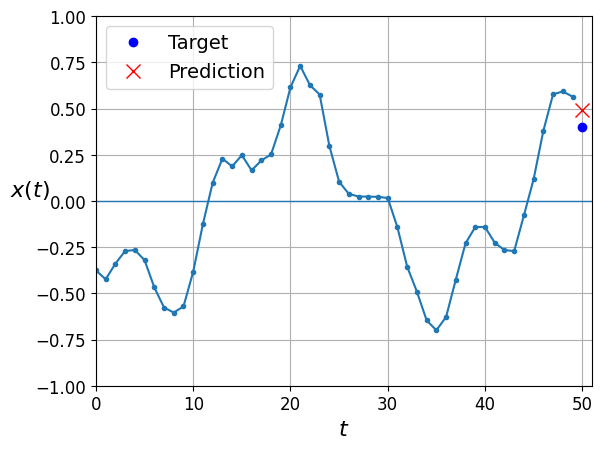

In [39]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], pred_valid[0, 0])
plt.show()

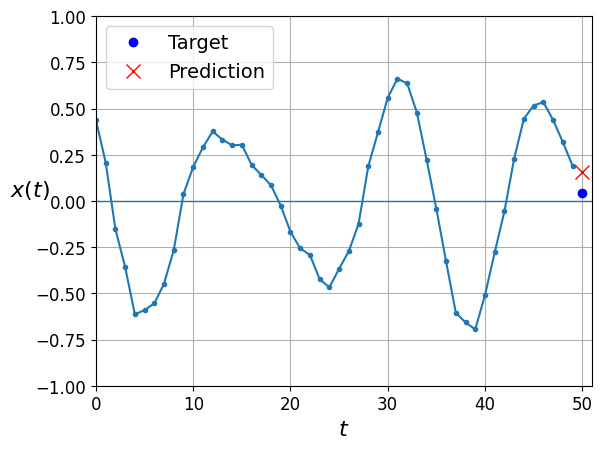

In [40]:
plot_series(X_test[0, :, 0], y_test[0, 0], pred_test[0, 0])
plt.show()

In [43]:
X_valid.shape

torch.Size([2000, 50, 1])

In [47]:
X_valid[1, :, 0]

tensor([-0.2530, -0.2427, -0.0897,  0.0306,  0.2831,  0.5034,  0.6832,  0.7171,
         0.6635,  0.4831,  0.3028,  0.2052,  0.0845,  0.0664,  0.1681,  0.0750,
         0.0133, -0.1378, -0.3255, -0.5051, -0.6772, -0.6718, -0.6012, -0.4114,
        -0.3083, -0.1150, -0.0672, -0.0552,  0.0184,  0.0074,  0.0284,  0.1513,
         0.4263,  0.6072,  0.6463,  0.7213,  0.6277,  0.4134,  0.1903,  0.0651,
        -0.0735, -0.1318, -0.0570, -0.0356, -0.0802, -0.2278, -0.4137, -0.6298,
        -0.7008, -0.6760])

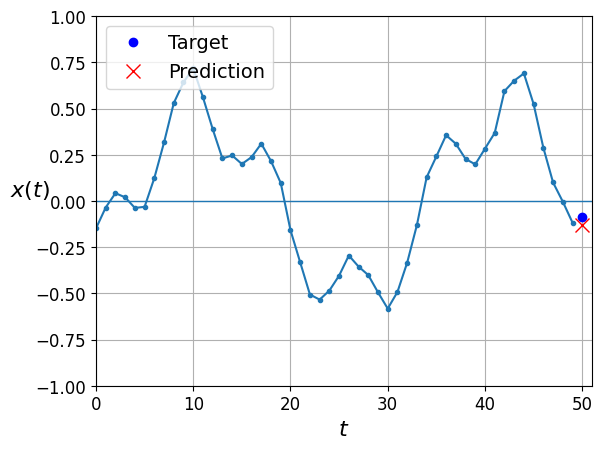

In [59]:
serie = 100
plot_series(X_valid[serie, :, 0], y_valid[serie, 0], pred_valid[serie, 0])
plt.show()

# GRU

In [161]:
L = 50
N = 7000
H_in = 1
H_out = 1
N_layers = 10

In [94]:
class MyFirstRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(H_in, H_out, N_layers, batch_first=True)

    def forward(self, x):
        out, h_i = self.rnn(x)
        return out[-1]

In [95]:
class MyFirstGRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(H_in, H_out, N_layers, batch_first=True)

    def forward(self, x):
        out, h_i = self.gru(x)
        return out[-1]

In [145]:
class MyFirstGRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(H_in, H_out, N_layers, batch_first=True)
        self.linear = nn.Linear(H_out, 1)  # Adiciona uma camada linear

    def forward(self, x):
        out, h_i = self.gru(x)
        out_last = out[-1]  # Pega apenas a última saída da sequência
        output_linear = self.linear(out_last)  # Passa a última saída pela camada linear
        return output_linear
        # return out_last

In [146]:
model = MyFirstGRU()

In [147]:
model(torch.rand(50, 1))

tensor([0.2508], grad_fn=<AddBackward0>)

In [148]:
summary(model, (50,1), verbose=2)

Layer (type:depth-idx)                   Output Shape              Param #
MyFirstGRU                               [1]                       --
├─GRU: 1-1                               [50, 10]                  390
│    └─weight_ih_l0                                                ├─30
│    └─weight_hh_l0                                                ├─300
│    └─bias_ih_l0                                                  ├─30
│    └─bias_hh_l0                                                  └─30
├─Linear: 1-2                            [1]                       11
│    └─weight                                                      ├─10
│    └─bias                                                        └─1
Total params: 401
Trainable params: 401
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01


Layer (type:depth-idx)                   Output Shape              Param #
MyFirstGRU                               [1]                       --
├─GRU: 1-1                               [50, 10]                  390
│    └─weight_ih_l0                                                ├─30
│    └─weight_hh_l0                                                ├─300
│    └─bias_ih_l0                                                  ├─30
│    └─bias_hh_l0                                                  └─30
├─Linear: 1-2                            [1]                       11
│    └─weight                                                      ├─10
│    └─bias                                                        └─1
Total params: 401
Trainable params: 401
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [149]:
LR = 1e-4
EPOCHS = 3
train_logs = defaultdict(list)

In [150]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

In [151]:
model.to(device)

MyFirstGRU(
  (gru): GRU(1, 10, batch_first=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)

In [152]:
optimizer.zero_grad(set_to_none=True)
for epoch in tqdm(range(EPOCHS)):
    model.train()
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False)
    for i, (inputs, labels) in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_logs['loss'].append(loss.item())
    print(f'Epoch: {epoch}')
        # loop.set_description(f"Epoch {epoch+1}/{EPOCHS}")
        # loop.set_postfix(loss=loss.item())

 33%|████████████████████████████                                                        | 1/3 [00:21<00:42, 21.23s/it]

Epoch: 0



 67%|████████████████████████████████████████████████████████                            | 2/3 [00:42<00:21, 21.42s/it]

Epoch: 1



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:04<00:00, 21.47s/it]

Epoch: 2


In [153]:
loss

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)

In [154]:
pred_valid = evaluete_model(model, valid_dataloader)

In [155]:
pred_test = evaluete_model(model, test_dataloader)

In [156]:
mean_absolute_error(y_valid, pred_valid)

0.0640454

In [157]:
mean_absolute_error(y_test, pred_test)

0.06781255

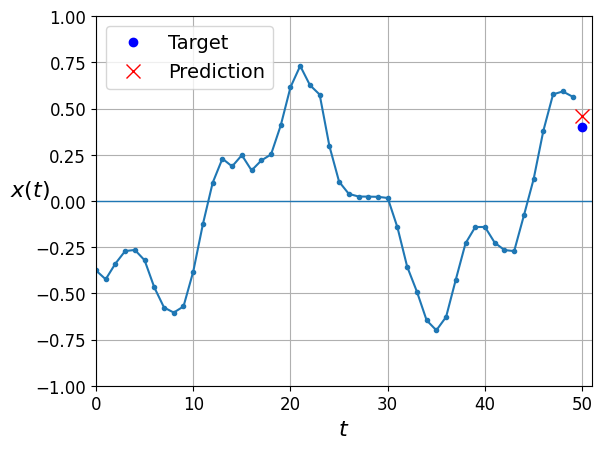

In [158]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], pred_valid[0, 0])
plt.show()

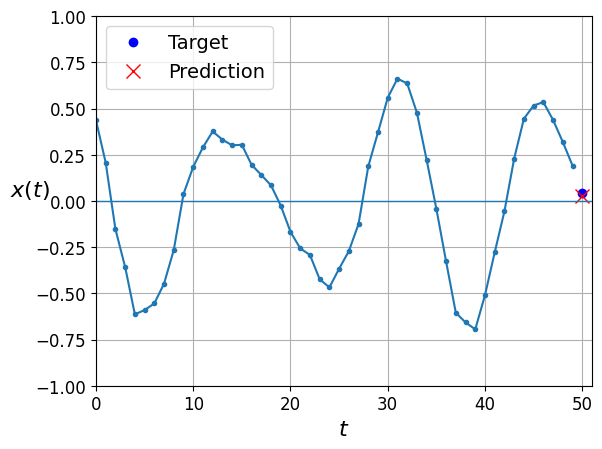

In [159]:
plot_series(X_test[0, :, 0], y_test[0, 0], pred_test[0, 0])
plt.show()

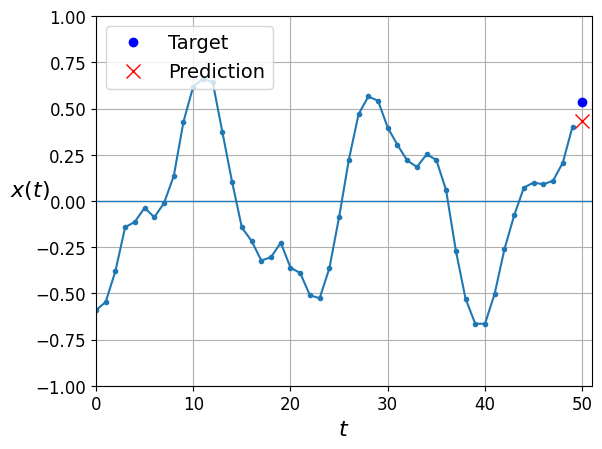

In [160]:
serie = 456
plot_series(X_valid[serie, :, 0], y_valid[serie, 0], pred_valid[serie, 0])
plt.show()

# LSTM

In [ ]:
class MyFirstLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(H_in, H_out, N_layers, batch_first=True)

    def forward(self, x):
        out, h_i = self.lstm(x)
        return out[-1]